# Общая информация
Целью является создание модели прогнозирования энергопотребления просьюмеров для снижения затрат на небаланс энергии.

Проект направлен на решение проблемы энергетического дисбаланса - ситуации, когда ожидаемое потребление энергии не совпадает с ее фактическим использованием или производством. Значительная часть энергетического дисбаланса приходится на потребителей, которые как потребляют, так и производят энергию. Несмотря на то, что они составляют лишь небольшую часть всех потребителей, их непредсказуемое потребление энергии создает логистические и финансовые проблемы для энергетических компаний.
 
*Enefit* – одна из крупнейших энергетических компаний Балтийского региона. Как эксперты в области энергетики, мы помогаем клиентам индивидуально и гибко планировать свой экологический путь, а также реализовывать его, используя экологически чистые энергетические решения.

В настоящее время Enefit пытается решить проблему дисбаланса, разрабатывая внутренние модели прогнозирования и опираясь на прогнозы третьих сторон. Однако эти методы оказались недостаточными из-за низкой точности прогнозирования энергетического поведения просьюмеров. Недостатки этих нынешних методов заключаются в их неспособности точно учесть широкий спектр переменных, влияющих на поведение потребителей, что приводит к высоким издержкам дисбаланса.

### Оценивание
Основной метрикой заказчика является MAE (средняя абсолютная ошибка):

$MAE = \dfrac{1}{n} \sum_{i=1}^n |y_i - x_i|$

Где:

- $n$ — общее количество объектов
- $y_i$ — прогнозируемое значение таргета
- $x_i$ — наблюдаемое значение таргета

### Глоссарий
**Просьюмер** — 
1. человек, который покупает электронные товары, являющиеся стандартом между товарами, предназначенными для потребителей, и профессионалами
2. потребитель, который участвует в разработке или настройке продуктов для своих собственных нужд

В текущем проекте считаем просьюмером любого потребителя электроэнергии.

**EICs** — European Identifier Code.

# Оглавление
1. [Предобработка данных](#preprocessing)
    1. [Знакомство с данными](#data-familiarization)
    2. [Удаление пропусков](#problem-solving)



In [1]:
##  Знакомство с данными <a class="anchor" id="data-familiarization"></a>

# Предобработка данных <a class="anchor" id="preprocessing"></a>

##  Знакомство с данными <a class="anchor" id="data-familiarization"></a>

In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import os

from typing import List

# запишем путь директории
basedir = os.path.abspath(os.getcwd())
sns.set_style("darkgrid")

In [3]:
# загрузим данные
try:
    clients = pd.read_csv(os.path.join(basedir, 'data/client.csv'))
    train = pd.read_csv(os.path.join(basedir, 'data/train.csv'))
    gas_prices = pd.read_csv(os.path.join(basedir, 'data/gas_prices.csv'))
    electricity_prices = pd.read_csv(os.path.join(basedir, 'data/electricity_prices.csv'))
    forecast_weather = pd.read_csv(os.path.join(basedir, 'data/forecast_weather.csv'))
    historical_weather = pd.read_csv(os.path.join(basedir, 'data/historical_weather.csv'))
    county_map = pd.read_json(os.path.join(basedir, 'data/county_id_to_name_map.json'), typ='series')
except:
    raise Exception('Check the files')

In [4]:
def get_dataset_info(df: pd.DataFrame) -> None:
    """
    Функция выводит общую инфу
    о датасете одним полем
    
    :param pd.DataFrame df: pandas-датафрейм, который нужно проанализировать
    """
    display(df.head())
    print('\n')
    print(df.info())
    print('\n')
    display(df.describe())
    print('\n')
    print(df.isna().sum())
    print('\n')
    print(f'Дубликаты: {df.duplicated().sum()}')
    print('it`s over')

In [5]:
get_dataset_info(clients)

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB
None




,product_type,county,eic_count,installed_capacity,is_business,data_block_id
count,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000
mean,1.898996,7.297097,73.345118,1450.771451,0.536773,322.898876
std,1.081713,4.780750,144.064389,2422.233120,0.498652,182.075724
min,0.000000,0.000000,5.000000,5.500000,0.000000,2.000000
25%,1.000000,3.000000,13.000000,321.900000,0.000000,167.000000
50%,2.000000,7.000000,32.000000,645.200000,1.000000,324.000000
75%,3.000000,11.000000,70.000000,1567.150000,1.000000,480.000000
max,3.000000,15.000000,1517.000000,19314.310000,1.000000,637.000000




product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
date                  0
data_block_id         0
dtype: int64


Дубликаты: 0
it`s over


Видим, что в этом датасете у нас 41919 объектов с обезличенной информацией о клиентах. Пропусков и полных дубликатов нет. Присутствуют следующие поля:
- **product_type** — тип продукта
- **county** — ID округа
- **eic_count** — количество точек потребления
- **installed_capacity** — установленная мощность фотоэлектрической солнечной панели в киловаттах
- **is_business** — является ли просьюмер бизнесом
- **date** — дата (вероятно, создания записи)
- **data_block_id** — все строки с одним и тем же data_block_id будут доступны в одно и то же время прогноза. Это зависит от того, какая информация доступна во время фактических прогнозов, каждое утро в 11 часов утра. Например, если прогноз погоды data_block_id для предсказаний, сделанных 31 октября, равен 100, то исторический data_block_id погоды на 31 октября будет равен 101, поскольку исторические данные о погоде фактически доступны только на следующий день.

In [6]:
get_dataset_info(train)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB
None




,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.018352e+06,2.018352e+06,2.018352e+06,2.017824e+06,2018352.0,2.018352e+06,2.018352e+06,2.018352e+06
mean,7.297034e+00,5.368261e-01,1.898927e+00,2.748556e+02,0.5,3.218746e+02,1.009176e+06,3.304538e+01
std,4.780990e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826343e+02,5.826482e+05,1.959059e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045878e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009176e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01




county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64


Дубликаты: 0
it`s over


В трейне у нас чуть более 2 миллионов объектов, у которых 528 пропусков в таргете. Учитывая, что их очень мало, эти строки просто удалим позже.
Поля:
- **county** — идентификационный код округа.
- **is_business** — логическое значение, определяющее, является ли просьюмер бизнесом.
- **product_type** — идентификационный код со следующим сопоставлением кодов типам контрактов: 
    - 0: «Комбинированный»
    - 1: «Фиксированный»
    - 2: «Общий сервис»
    - 3: «Спотовый»
- **target** — объем потребления или производства для соответствующего сегмента за час. Сегменты определяются округом, is_business и Product_type.
- **is_consumption** — логическое значение, указывающее, является ли целью этой строки потребление или производство.
- **datetime** — эстонское время в формате EET (UTC+2) / EEST (UTC+3).
- **data_block_id** — все строки с одним и тем же data_block_id будут доступны в одно и то же время прогноза. Это зависит от того, какая информация доступна во время фактических прогнозов, каждое утро в 11 часов утра. Например, если прогноз погоды data_block_id для предсказаний, сделанных 31 октября, равен 100, то исторический data_block_id погоды на 31 октября будет равен 101, поскольку исторические данные о погоде фактически доступны только на следующий день.
- **row_id** — уникальный идентификатор строки.
- **prediction_unit_id** — уникальный идентификатор для комбинации округа, is_business и Product_type. Новые единицы прогнозирования могут появляться или исчезать в тестовом наборе.

In [7]:
get_dataset_info(gas_prices)

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB
None




,lowest_price_per_mwh,highest_price_per_mwh,data_block_id
count,637.000000,637.000000,637.000000
mean,95.036750,107.754631,319.000000
std,47.552295,54.743666,184.030342
min,28.100000,34.000000,1.000000
25%,60.000000,67.530000,160.000000
50%,85.210000,93.470000,319.000000
75%,109.000000,130.740000,478.000000
max,250.000000,305.000000,637.000000




forecast_date            0
lowest_price_per_mwh     0
highest_price_per_mwh    0
origin_date              0
data_block_id            0
dtype: int64


Дубликаты: 0
it`s over


Здесь у нас информация по прогнозу цен на топливо.
- **origin_date** — дата, когда стали доступны цены на сутки вперед.
- **forecast_date**  — дата, когда прогнозные цены должны быть актуальными.
- **(lowest/highest)_price_per_mwh** — самая низкая/самая высокая цена природного газа, которая будет продаваться на день вперед в этот торговый день, в евро за эквивалент мегаватт-часа.
- **data_block_id**

In [8]:
get_dataset_info(electricity_prices)

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB
None




,euros_per_mwh,data_block_id
count,15286.000000,15286.000000
mean,157.064176,318.990710
std,121.148625,183.890301
min,-10.060000,1.000000
25%,85.290000,160.000000
50%,128.280000,319.000000
75%,199.797500,478.000000
max,4000.000000,637.000000




forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64


Дубликаты: 0
it`s over


Данные по ценам на электричество (почти аналогично газу):

- **origin_date**
- **forecast_date**
- **euros_per_mwh** — цена на электроэнергию на завтрашний день торгуется в евро за мегаватт-час.
- **data_block_id**

In [9]:
get_dataset_info(forecast_weather)

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall        

,latitude,longitude,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
count,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424512e+06,3.424510e+06,3.424512e+06,3.424512e+06
mean,5.865000e+01,2.495000e+01,2.450000e+01,5.743913e+00,2.411946e+00,3.946654e-01,4.346453e-01,3.590693e-01,6.819927e-01,1.255446e+00,7.250110e-01,3.190000e+02,1.511882e+02,1.107642e+02,2.533923e-05,7.863859e-05
std,6.873865e-01,2.015565e+00,1.385340e+01,7.844206e+00,7.121432e+00,4.440425e-01,4.386346e-01,4.201556e-01,4.009629e-01,3.995300e+00,4.223752e+00,1.838859e+02,2.565069e+02,1.874444e+02,1.222840e-04,2.780880e-04
min,5.760000e+01,2.170000e+01,1.000000e+00,-2.749940e+01,-2.968357e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.757718e+01,-2.211612e+01,1.000000e+00,-7.733333e-01,-3.258333e-01,-3.814697e-06,-1.529098e-05
25%,5.812500e+01,2.320000e+01,1.275000e+01,2.606445e-01,-2.364355e+00,0.000000e+00,3.356934e-04,0.000000e+00,2.648926e-01,-1.466691e+00,-1.978108e+00,1.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.865000e+01,2.495000e+01,2.450000e+01,4.872705e+00,1.835596e+00,8.866882e-02,2.305453e-01,1.011963e-01,9.772670e-01,1.468681e+00,9.433203e-01,3.190000e+02,0.000000e+00,6.044444e-01,0.000000e+00,0.000000e+00
75%,5.917500e+01,2.670000e+01,3.625000e+01,1.114639e+01,7.302026e+00,9.784851e-01,9.994587e-01,9.000854e-01,1.000000e+00,3.813533e+00,3.507629e+00,4.780000e+02,2.128447e+02,1.441723e+02,0.000000e+00,2.765656e-05
max,5.970000e+01,2.820000e+01,4.800000e+01,3.181069e+01,2.368057e+01,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,2.257320e+01,1.931437e+01,6.370000e+02,9.544222e+02,8.487144e+02,4.832983e-03,1.651621e-02




latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    2
snowfall                             0
total_precipitation                  0
dtype: int64


Дубликаты: 0
it`s over


Прогнозы погоды, которые были бы доступны на момент прогнозирования от Европейского центра среднесрочных прогнозов погоды. 3,5 миллионов записей.

- **latitude, longitude** — координаты прогноза погоды.
- **origin_datetime** — временная метка создания прогноза.
- **hours_ahead** — количество часов между созданием прогноза и прогнозом погоды. Каждый прогноз охватывает в общей сложности 48 часов.
- **temperature** — температура воздуха на высоте 2 метра над землей в градусах Цельсия.
- **dewpoint** — температура точки росы на высоте 2 метра над землей в градусах Цельсия.
- **cloudcover_(low/mid/high/total)** — процент неба, покрытого облаками в следующих диапазонах высот: 0–2 км, 2–6, 6+ и общий.
- **10_metre_(u/v)_wind_component** — составляющая скорости ветра (восточное/северное направление), измеренная на высоте 10 метров над поверхностью земли в метрах в секунду.
- **data_block_id**
- **forecast_datetime** — временная метка прогнозируемой погоды. Генерируется из origin_datetime плюс hours_ahead.
- **direct_solar_radiation** — прямая солнечная радиация, достигающая поверхности в плоскости, перпендикулярной направлению Солнца, накопленная за предыдущий час, в ватт-часах на квадратный метр.
- **surface_solar_radiation_downwards** — солнечное излучение, как прямое, так и рассеянное, достигающее горизонтальной плоскости на поверхности Земли, в ватт-часах на квадратный метр.
- **snowfall** — снегопад за предыдущий час в метрах водного эквивалента.
- **total_precipitation** — накопленная жидкость, состоящая из дождя и снега, выпавшая на поверхность Земли за предыдущий час, в метрах.

In [10]:
get_dataset_info(historical_weather)

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710800 entries, 0 to 1710799
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   datetime                object 
 1   temperature             float64
 2   dewpoint                float64
 3   rain                    float64
 4   snowfall                float64
 5   surface_pressure        float64
 6   cloudcover_total        int64  
 7   cloudcover_low          int64  
 8   cloudcover_mid          int64  
 9   cloudcover_high         int64  
 10  windspeed_10m           float64
 11  winddirection_10m       int64  
 12  shortwave_radiation     float64
 13  direct_solar_radiation  float64
 14  diffuse_radiation       float64
 15  latitude                float64
 16  longitude               float64
 17  data_block_id           int64  
dtypes: float64(11), int64(6), object(1)
memory usage: 234.9+ MB
None




,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
count,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06,1.710800e+06
mean,5.703857e+00,2.209087e+00,4.949369e-02,1.612128e-02,1.009281e+03,6.102065e+01,4.682182e+01,3.445699e+01,3.608472e+01,4.854635e+00,1.978516e+02,1.059350e+02,6.404775e+01,4.188727e+01,5.865000e+01,2.495000e+01,3.192706e+02
std,8.012687e+00,7.211465e+00,2.064676e-01,7.485325e-02,1.309908e+01,3.775467e+01,4.076018e+01,3.835464e+01,4.137401e+01,2.478987e+00,8.992159e+01,1.793882e+02,1.329057e+02,6.184148e+01,6.873866e-01,2.015565e+00,1.837299e+02
min,-2.370000e+01,-2.590000e+01,0.000000e+00,0.000000e+00,9.429000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.760000e+01,2.170000e+01,1.000000e+00
25%,0.000000e+00,-2.700000e+00,0.000000e+00,0.000000e+00,1.001500e+03,2.500000e+01,3.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.390000e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.812500e+01,2.320000e+01,1.600000e+02
50%,5.100000e+00,1.600000e+00,0.000000e+00,0.000000e+00,1.010400e+03,7.200000e+01,4.000000e+01,1.600000e+01,1.000000e+01,4.500000e+00,2.080000e+02,1.000000e+00,0.000000e+00,1.000000e+00,5.865000e+01,2.495000e+01,3.190000e+02
75%,1.110000e+01,7.200000e+00,0.000000e+00,0.000000e+00,1.018000e+03,1.000000e+02,9.400000e+01,7.200000e+01,8.600000e+01,6.277778e+00,2.630000e+02,1.380000e+02,4.700000e+01,7.400000e+01,5.917500e+01,2.670000e+01,4.780000e+02
max,3.260000e+01,2.260000e+01,1.680000e+01,2.660000e+00,1.049300e+03,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,2.175000e+01,3.600000e+02,8.480000e+02,7.390000e+02,3.860000e+02,5.970000e+01,2.820000e+01,6.370000e+02




datetime                  0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
latitude                  0
longitude                 0
data_block_id             0
dtype: int64


Дубликаты: 0
it`s over


Исторические данные погоды. 

- **datetime**
- **temperature**
- **dewpoint**
- **rain** — разница от условных обозначений прогноза. Дождь от крупномасштабных погодных систем за предыдущий час в миллиметрах.
- **snowfall** — разница от условного прогноза. Снегопад за предыдущий час в сантиметрах.
- **surface_pressure** — давление воздуха на поверхности в гектопаскалях.
- **cloudcover_(low/mid/high/total)** — разница от прогноза. Облачность на высоте 0–3 км, 3–8, 8+ и общая.
- **windspeed_10m** — разница от прогноза. Скорость ветра на высоте 10 метров над землей в метрах в секунду.
- **winddirection_10m** — разница от прогноза. Направление ветра на высоте 10 метров над землей в градусах.
- **shortwave_radiation** — разница от прогноза. Глобальное горизонтальное излучение в ватт-часах на квадратный метр.
- **direct_solar_radiation**
- **diffuse_radiation** — разница от прогноза. Диффузное солнечное излучение в ватт-часах на квадратный метр.
- **(latitude/longitude)** — координаты метеостанции.
- **data_block_id**

In [11]:
county_map

0          HARJUMAA
1           HIIUMAA
2       IDA-VIRUMAA
3          JÄRVAMAA
4         JÕGEVAMAA
5     LÄÄNE-VIRUMAA
6          LÄÄNEMAA
7          PÄRNUMAA
8          PÕLVAMAA
9          RAPLAMAA
10         SAAREMAA
11         TARTUMAA
12          UNKNOWN
13         VALGAMAA
14      VILJANDIMAA
15          VÕRUMAA
dtype: object

Эта информация связывает id с названиями округов Эстонии.

## Удаление пропусков <a class="anchor" id="problem-solving"></a>

Сначала удалим пропуски в таблице train. Их там примерно полтысячи.

In [12]:
train = train.dropna(subset='target')
train.isna().sum()

county                0
is_business           0
product_type          0
target                0
is_consumption        0
datetime              0
data_block_id         0
row_id                0
prediction_unit_id    0
dtype: int64

In [13]:
# то же самое для предсказанной погоды
forecast_weather = forecast_weather.dropna(subset='surface_solar_radiation_downwards')
forecast_weather.isna().sum()

latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    0
snowfall                             0
total_precipitation                  0
dtype: int64

## Изменение типов данных

Изменим даты в датасетах на тип `datetime`.

In [14]:
def change_datetime_type(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    """
    Функция меняет тип указанных полей на datetime
    :param pd.DataFrame df: Pandas-датафрейм, в котором нужно изменить поля
    :param List[str] columns: список столбцов с датами
    """
    if not columns:
        return Exception('Список столбцов не может быть пустым / Указание столбцов таблицы обязательно')
    for col in columns:
        df[col] = pd.to_datetime(df[col])
        df[col] = df[col].dt.strftime('%Y-%m-%d %H:%M:%S')
    return df

In [15]:
clients = change_datetime_type(clients, ['date'])
train = change_datetime_type(train, ['datetime'])
gas_prices = change_datetime_type(gas_prices, ['forecast_date', 'origin_date'])
electricity_prices = change_datetime_type(electricity_prices, ['forecast_date', 'origin_date'])
forecast_weather = change_datetime_type(forecast_weather, ['origin_datetime', 'forecast_datetime'])
historical_weather = change_datetime_type(historical_weather, ['datetime'])

## EDA

Теперь проведем разведывательный анализ данных для более глубокого погружения в данные. Сначала проверим совпадение временных промежутков в датасетах, так как работать нам придется с временными рядами.

In [16]:
# оценим, какие временные промежутки в данных заказчика
def show_min_max_date(data: pd.Series) -> None:
    """
    Функция печатает минимальную и максимальную даты для нужного поля
    :param pd.Series data: Series-объект Pandas с датами
    """
    print(f'Минимальная дата: {data.min()}')
    print(f'Максимальная дата: {data.max()}')

In [17]:
show_min_max_date(clients['date'])

Минимальная дата: 2021-09-01 00:00:00
Максимальная дата: 2023-05-29 00:00:00


In [18]:
show_min_max_date(train['datetime'])

Минимальная дата: 2021-09-01 00:00:00
Максимальная дата: 2023-05-31 23:00:00


In [19]:
show_min_max_date(gas_prices['forecast_date'])
show_min_max_date(gas_prices['origin_date'])

Минимальная дата: 2021-09-01 00:00:00
Максимальная дата: 2023-05-30 00:00:00
Минимальная дата: 2021-08-31 00:00:00
Максимальная дата: 2023-05-29 00:00:00


In [20]:
show_min_max_date(electricity_prices['forecast_date'])
show_min_max_date(electricity_prices['origin_date'])

Минимальная дата: 2021-09-01 00:00:00
Максимальная дата: 2023-05-30 23:00:00
Минимальная дата: 2021-08-31 00:00:00
Максимальная дата: 2023-05-29 23:00:00


In [21]:
show_min_max_date(forecast_weather['origin_datetime'])
show_min_max_date(forecast_weather['forecast_datetime'])

Минимальная дата: 2021-09-01 00:00:00
Максимальная дата: 2023-05-30 00:00:00
Минимальная дата: 2021-09-01 01:00:00
Максимальная дата: 2023-06-01 00:00:00


In [22]:
show_min_max_date(historical_weather['datetime'])

Минимальная дата: 2021-09-01 00:00:00
Максимальная дата: 2023-05-30 10:00:00


Видим, что периоды даны одинаковые, так что с этим проблем возникнуть не должно. Посмотрим теперь на таблицу `train`, что будет для нас основной в дальнейшей работе.

,is_business
1,1083222
0,934602


<AxesSubplot: >

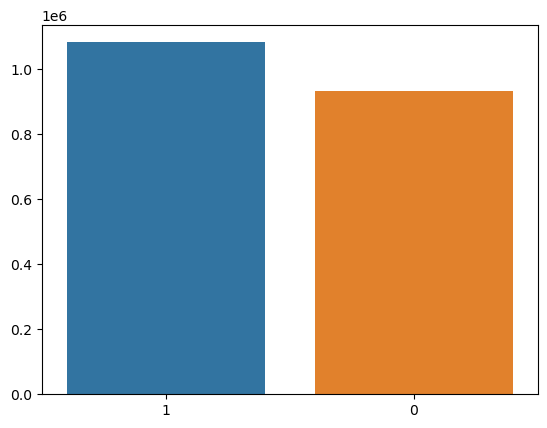

In [23]:
# взглянем на распределение просьюмеров b2b И b2c
is_business = pd.DataFrame(train['is_business'].value_counts())
display(is_business)
display(sns.barplot(data=is_business.T))

Как видим, бизнеса чуть больше, чем обычных потребителей.

In [26]:
# посмотрим то же на тип продукта
train['product_type'].value_counts()

3    918480
1    781428
0    170500
2    147416
Name: product_type, dtype: int64

Как видим большинство контрактов спотовые, вторые по используемости фиксированные тарифы, а дальше комбинированный и общий сервис. Посмотрим в разрезе типов клиентов.

In [39]:
train.pivot_table(index='product_type', columns='is_business', values='target' aggfunc='count')

is_business,0,1
product_type,,
0,NaN,170500.0
1,427184.0,354244.0
2,78794.0,68622.0
3,428624.0,489856.0


Можно обратить внимание, что комбинированным типов бользуется только бизнес, а для остальных более менее поровну. Давайте также взглянем, как много тех, потребляет электроэнергию для производства и по другим нуждам.

In [40]:
train['is_consumption'].value_counts()

0    1008912
1    1008912
Name: is_consumption, dtype: int64

Удивительно, но разницы нет нет вовсе, обеих групп ровно поровну.

In [41]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


Изучим временные ряды по разным годам, а потребление просуммируем. Потом ресемплируем по дням или неделям, после чего посчитаем среднее с графиком.

In [61]:
date_and_target = pd.DataFrame(train[['datetime', 'target']].groupby('datetime')['target'].sum())
date_and_target.head()

,target
datetime,
2021-09-01 00:00:00,19864.170
2021-09-01 01:00:00,19276.930
2021-09-01 02:00:00,19262.737
2021-09-01 03:00:00,19028.001
2021-09-01 04:00:00,19369.616


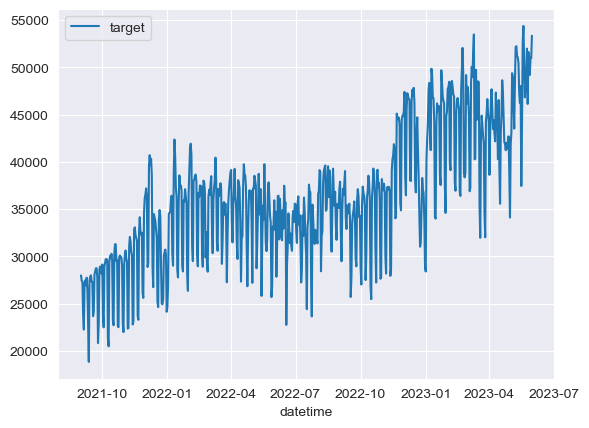

In [75]:
# сдедаем копию датафрейма
date_and_target_re = date_and_target.copy()

# изменим тип индекса
date_and_target_re.index = pd.to_datetime(date_and_target_re.index)

# ресеплируем по дням и выведем графиком
sns.lineplot(date_and_target_re.resample('1D').mean());

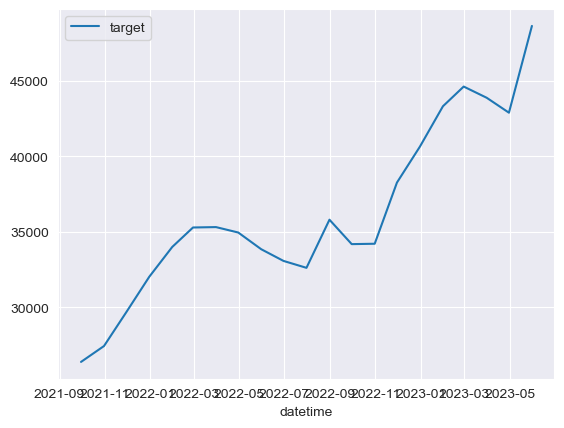

In [74]:
# сдедаем то же для месяцев
sns.lineplot(date_and_target_re.resample('1M').mean());

Видим тренд постоянного увеличения потребления электроэнергии. Взглянем в разрезе одного года.

<AxesSubplot: xlabel='datetime'>

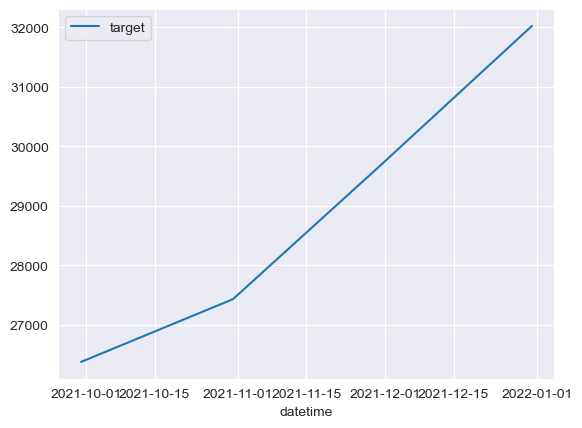

In [87]:
# для месяцев 2021 года
display(sns.lineplot(date_and_target_re.query('index < "2022-01-01"').resample('1M').mean()))

<AxesSubplot: xlabel='datetime'>

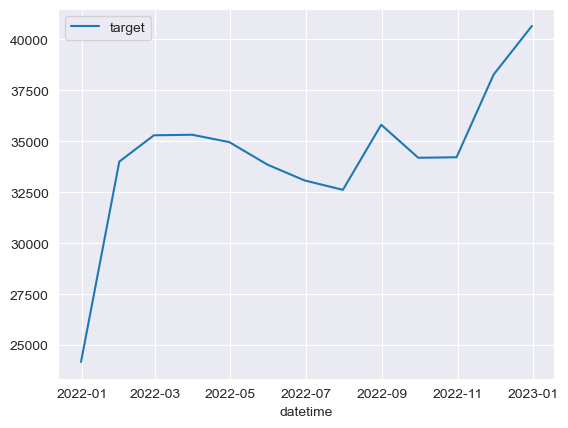

In [88]:
# для месяцев 2022 года
display(sns.lineplot(date_and_target_re.query('index > "2021-12-31" and index < "2023-01-01"').resample('1M').mean()));

<AxesSubplot: xlabel='datetime'>

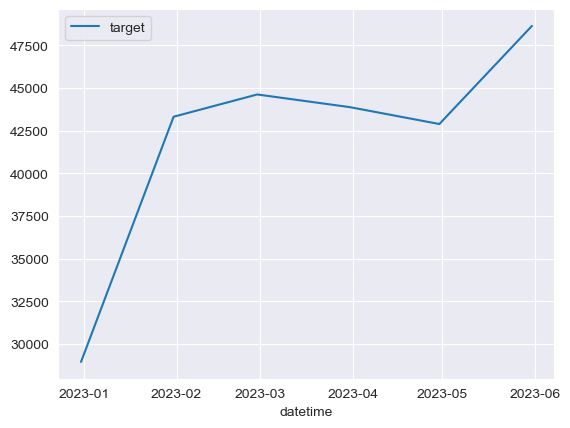

In [89]:
# для месяцев 2023 года
display(sns.lineplot(date_and_target_re.query('index > "2022-12-31"').resample('1M').mean()));